# PRACTICA TEXTO

### Por Patricio Ávila, Jaime Hormaeche y Jose Manuel Pérez 

Lo primero que vamos a hacer es leer el fichero csv y analizarlo para encontrar caracteristicas que nos ayuden a realizar un mejor problema.

In [ ]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Preprocesamiento y modelado
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# NLP
import re
import string
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Embedding, LSTM, concatenate, Flatten
from keras.optimizers import Adam

# Transformers (para BERT)
from transformers import TFBertModel, BertTokenizer

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Otros
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('fifa_world_cup_2022_tweets.csv', encoding='latin-1')

In [6]:
df.head()

,Unnamed: 0,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
0,0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe \n@MadB...,neutral
1,1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,positive
2,2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,positive
3,3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,positive
4,4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",negative


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22524 entries, 0 to 22523
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       22524 non-null  int64 
 1   Date Created     22524 non-null  object
 2   Number of Likes  22524 non-null  int64 
 3   Source of Tweet  22524 non-null  object
 4   Tweet            22524 non-null  object
 5   Sentiment        22524 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.0+ MB


In [8]:
df.shape

(22524, 6)

Aqui vemos que no tiene valores nulos en ninguna columna y que no tiene filas duplicadas, que deberíamos eliminar.

In [9]:
df.isnull().sum()


Unnamed: 0         0
Date Created       0
Number of Likes    0
Source of Tweet    0
Tweet              0
Sentiment          0
dtype: int64

In [10]:
df.duplicated().sum()

0

Vamos a transformar el sentimiento a un valor numerico ya que permite realizar calculos y analisis más facilmente. Esta representacion numerica de los sentimientos nos permite tambien aplicar tecnicas estadisticas y algoritmos de clasificacion para patrones y hacer modelos, cosa que es el fin de este proyecto.

In [11]:
# Create a dictionary to map Sentiment to a numerical value.
class_map = {
    "negative": 0,
    "neutral" : 1,
    "positive": 2
}

#New clumn class for the mapped data
df['Sent_Num'] = df.Sentiment.map(class_map)
df.head()

,Unnamed: 0,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment,Sent_Num
0,0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe \n@MadB...,neutral,1
1,1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,positive,2
2,2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,positive,2
3,3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,positive,2
4,4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",negative,0


Vamos a realizar unas gráficas para ver ciertas caracteristicas que no tienen que ver con el sentimiento a primera vista pero que pueden ser utiles e interesantes-

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Twitter for iPhone'),
  Text(1, 0, 'Twitter for Android'),
  Text(2, 0, 'Twitter Web App'),
  Text(3, 0, 'TweetDeck'),
  Text(4, 0, 'Twitter for iPad'),
  Text(5, 0, 'Qualtrics Social Connect'),
  Text(6, 0, 'Hootsuite Inc.'),
  Text(7, 0, 'Buffer'),
  Text(8, 0, 'Instagram'),
  Text(9, 0, 'Tweetbot for iÎ\x9fS')])

c:\Users\Josed\anaconda3\envs\datos_no_estructurados\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 159 (\x9f) missing from current font.
  func(*args, **kwargs)
c:\Users\Josed\anaconda3\envs\datos_no_estructurados\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 159 (\x9f) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


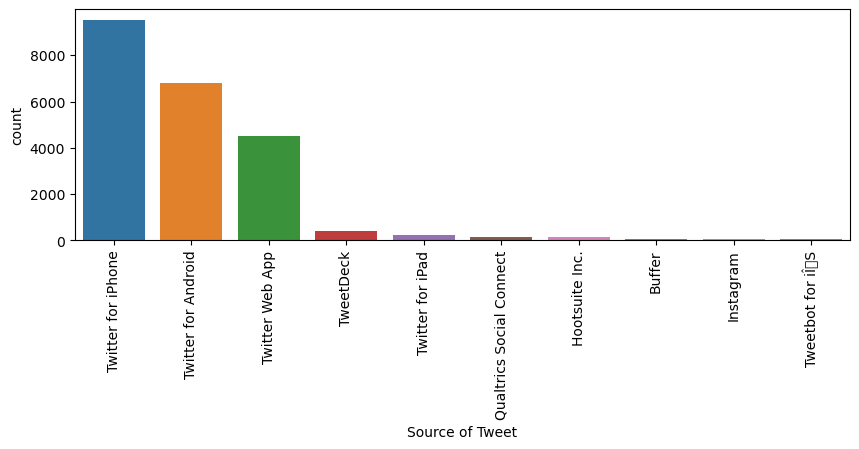

In [13]:
plt.figure(figsize = (10,3))
sns.countplot(data = df , x = "Source of Tweet" ,
              order = df['Source of Tweet'].value_counts(ascending = False).iloc[:10].index)

plt.xticks(rotation = 90)

<Axes: >

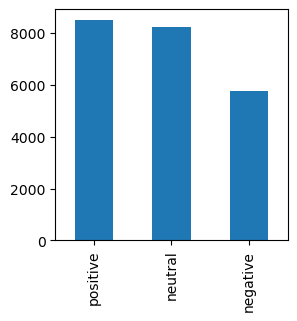

In [14]:
plt.figure(figsize = (3,3));
sentiment_count = df['Sentiment'].value_counts()
sentiment_count.plot(kind = "bar")

Después, hemos leido que en sentiment analysis que se extrae de internet, y sobre todo en una red social como Twiter, en la que la gente escribo como y lo que quiere, es necesario hacer una limpieza de los datos muy exhaustiva e indicar a nuestro modelo ciertas cosas que sino no podrá interpretar.  
Lo primero de todo será indicarle contracciones que se utilizan en inglés, ya que hay muchisimas y nuestros tweets son en ingles. Tenemos primeramente las contracciones de los verbos y luego contracciones coloquiales que se utilizan en lenguaje informal en ingles.

In [16]:
stop_words = stopwords.words("english")
stop_words.append("and")

In [17]:
# List of Contractions to be removed
contracciones = {
    "a'ight":"alright",
    "ain't":"are not",
    "amn't":"am not",
    "aren't":"are not",
    "can't":"cannot",
    "'cause": "because",
    "could've":"could have",
    "couldn't":"could not",
    "couldn't've":"could not have",
    "daren't":"dare not",
    "daresn't":"dare not",
    "dasn't":"dare not",
    "didn't":"did not",
    "doesn't":"does not",
    "don't":"do not",
    "everybody's":"everybody is",
    "everyone's":"everyone is",
    "giv'n":"given",
    "gonna":"going to",
    "gon't":"go not", 
    "gotta":"got to",
    "hadn't":"had not",
    "had've":"had have",
    "hasn't":"has not",
    "haven't":"have not",
    "he'd":"he had", 
    "he'll":"he will",
    "he's":"he is",
    "here's":"here is",
    "how'd":"how did",
    "how'll":"how will",
    "how're":"how are",
    "how's":"how is",
    "I'd":"I had",
    "I'd've":"I would have",
    "I'd'nt":"I would not",
    "I'd'nt've":"I would not have",
    "I'll":"I will",
    "I'm":"I am",
    "I've":"I have",
    "isn't":"is not",
    "it'd":"it would",
    "it'll":"it will",
    "it's":"it is",
    "let's":"let us",
    "ma'am":"madam",
    "mayn't":"may not",
    "may've":"may have",
    "mightn't":"might not",
    "might've":"might have",
    "mustn't":"must not",
    "mustn't've":"must not have",
    "must've":"must have",
    "needn't":"need not",
    "needn't've":"need not have",
    "o'clock":"of the clock",
    "oughtn't":"ought not",
    "oughtn't've":"ought not have",
    "shan't":"shall not",
    "she'd":"she would",
    "she'll":"she will",
    "she's":"she is",
    "should've":"should have",
    "shouldn't":"should not",
    "shouldn't've":"should not have",
    "somebody's":"somebody is",
    "someone's":"someone is",
    "something's":"something is",
    "so're":"so are",
    "so’s":"so is",
    "so’ve":"so have",
    "that'll":"that will",
    "that're":"that are",
    "that's":"that is",
    "that'd":"that would",
    "there'd":"there would",
    "there'll":"there will",
    "there're":"there are",
    "there's":"there is",
    "these're":"these are",
    "these've":"these have",
    "they'd":"they would",
    "they'll":"they will",
    "they're":"they are",
    "they've":"they have",
    "this's":"this is",
    "those're":"those are",
    "those've":"those have",
    "to've":"to have",
    "wasn't":"was not",
    "we'd":"we would",
    "we'd've":"we would have",
    "we'll":"we will",
    "we're":"we are",
    "we've":"we have",
    "weren't":"were not",
    "what'd":"what did",
    "what'll":"what will",
    "what're":"what are",
     "what's":"what is",
    "what've":"what have",
    "when's":"when is",
    "where'd":"where did",
    "where'll":"where will",
    "where're":"where are",
    "where's":"where is",
    "where've":"where have",
    "which'd":"which would",
    "which'll":"which will",
    "which're":"which are",
    "which's":"which is",
    "which've":"which have",
    "who'd":"who would",
    "who'd've":"who would have",
    "who'll":"who will",
    "who're":"who are",
    "who's":"who is",
    "who've":"who have",
    "why'd":"why did",
     "why're":"why are",
    "why's":"why is",
    "won't":"will not",
    "would've":"would have",
    "wouldn't":"would not",
    "wouldn't've":"would not have",
    "y'at":"you at",
    "yes’m":"yes madam",
    "you'd":"you would",
    "you'll":"you will",
    "you're":"you are",
    "you've":"you have"
}

In [18]:
abreviaciones = {
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
     "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
     "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
      "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
     "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
     "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
      "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
     "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
     "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
     "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
      "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [19]:
def expand_contractions(x):
    if type(x) is str:
        x = x.replace('\\','')
        for key in contracciones:
            value = contracciones[key]
            x = x.replace(key, value)
        return x
    else:
        return x
    
def expand_abbreviations(sentence):
    final_words=[]
    words=sentence.split()
    final_words= [abreviaciones[w.lower()] if w.lower() in abreviaciones.keys() else w for w in words]
    return " ".join(final_words)

Aqui seguimos con una tercera funcion que engloba las otras dos funciones de limpieza y que además hace otras cosas tales como:  
- convierte a minusculas
- elimina las menciones a usuarios (@) 
- se eliminan emojis que puedan haber
- elimina caracteres de puntuacion
- tokeniza el tweet
- quita cosas que no son alfabeticas
- elimina stopwords (en ingles, segun lo que hemos importado antes).  
 
Y ya luego finalente lo une todo con un join y creamos una nueva columna.

In [20]:
def clean_text(sentence):
    sentence = sentence.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    sentence = pattern.sub('', sentence)
    sentence = " ".join(filter(lambda x:x[0]!='@', sentence.split()))
    emo = re.compile("["
                           u"\U0001F600-\U0001FFFF"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF" 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE
                    )
    sentence = emo.sub(r'', sentence)
    sentence = sentence.lower()
    sentence = expand_contractions(sentence)
    sentence = expand_abbreviations(sentence)
    sentence = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", sentence)
    tokens = word_tokenize(sentence)
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    stop_words = set(stopwords.words("english"))
    words = [w for w in words if not w in stop_words]
    return " ".join(words)

#applying clean_text function to all tweets from dataset
df['cleaned_tweets'] = df['Tweet'].apply(lambda x: clean_text(x))
df['cleaned_tweets']

0                                           drinking today
1        amazing launch video shows much face canada na...
2                                   worth reading watching
3        golden maknae shinning bright jeonjungkook jun...
4        british broadcasting corporation cares much hu...
                               ...                        
22519                                         go world cup
22520    anderlecht confirms former viborg ffs jesper f...
22521                              great thread read start
22522                         raphinha wants brazil united
22523    buy sot confused buy tokens pinksale simple st...
Name: cleaned_tweets, Length: 22524, dtype: object

In [21]:
df.head()

,Unnamed: 0,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment,Sent_Num,cleaned_tweets
0,0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe \n@MadB...,neutral,1,drinking today
1,1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,positive,2,amazing launch video shows much face canada na...
2,2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,positive,2,worth reading watching
3,3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,positive,2,golden maknae shinning bright jeonjungkook jun...
4,4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",negative,0,british broadcasting corporation cares much hu...


Aqui vamos a crear un mapa de palabras para ver que tenga sentido.
Efectivamente vemos que las palabras más repetidas son las siguientes:
- world cup (Principal tema de lo que analizamos)
- fifa (Organizacion que lleva este evento)
- qatar (Lugar donde se celebra este evento).  

Y mas como gol, footbal, ceremonia que forman parte del ámbito de nuestro tema.

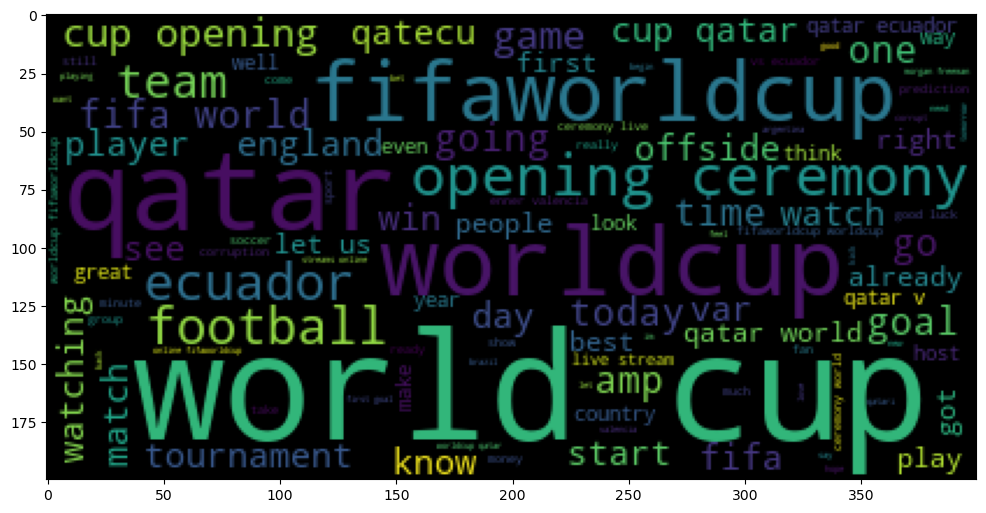

In [22]:
words = df['cleaned_tweets'].tolist()
combined_words = " ".join(words)
plt.figure(figsize = (12,10))
plt.imshow(WordCloud().generate(combined_words))
plt.show()

## **Modelo BERT**

En esta sección, se va a entrenar un modelo mediante un modelo ya creado por google llamado BERT ("Bidirectional Encoder Representations from Encoders"), el cual fue creado en 2018. \
Por tanto, vamos a emplear un modelo preentrenado para ver que tal funciona con nuestro dataset.

In [24]:
# Convertir a datetime
df['Date Created'] = pd.to_datetime(df['Date Created'])

# Extraer características
df['day_of_week'] = df['Date Created'].dt.dayofweek
df['hour_of_day'] = df['Date Created'].dt.hour

Aquí vamos a añadir nuevas variables, el día de la semana y la hora del día

In [26]:
from transformers import BertTokenizer

# Cargar el Tokenizador BERT pre-entrenado
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizar los tweets
df['tokens'] = df['cleaned_tweets'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

Vamos a cargar el tokenizador del modelo BERT y lo vamos a aplicar a los tweets limpiados previamente. \
Esto lo vamos a guardar en la variable "tokens".

In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Añadir padding a las secuencias
max_len = df['tokens'].apply(len).max()
df['tokens'] = pad_sequences(df['tokens'], maxlen=max_len, padding='post').tolist()


En este paso, se busca añadir el padding con el objetivo de poder obtener listas de un tamaño fijo, \
ya que todos los inputs deben tener el mismo tamaño.

In [28]:
from tensorflow.keras.utils import to_categorical

# Convertir las etiquetas a one-hot encoding
one_hot_labels = to_categorical(df['Sent_Num'])

Se guarda en la variable "one_hot_lables" el one-hot encoding de la variable "sent_num"

In [29]:
# Dividir los datos en conjuntos de entrenamiento y validación
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df['tokens'].tolist(), one_hot_labels, test_size=0.2, random_state=42)

In [30]:
# Crear tf.data.Dataset para el entrenamiento y la validación
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(32)

In [31]:
print(df['Sent_Num'].value_counts())


2    8489
1    8251
0    5784
Name: Sent_Num, dtype: int64


In [34]:
from transformers import TFBertModel
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# Inicializar el modelo BERT
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Definir las entradas
input_ids = Input(shape=(max_len,), dtype=tf.int32)

# Pasar las entradas por el modelo BERT
sequence_output = bert_model(input_ids)[0][:, 0, :]

# Añadir una capa de dropout para prevenir el overfitting
x = Dropout(0.1)(sequence_output)

# Añadir la capa de salida
out = Dense(3, activation='softmax')(x)

# Crear el modelo
model = Model(inputs=input_ids, outputs=out)

# Compilar el modelo
model.compile(Adam(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(train_dataset, epochs=3, validation_data=val_dataset)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/3


564/564 [==============================] - 3551s 6s/step - loss: 1.1607 - accuracy: 0.3595 - val_loss: 1.1059 - val_accuracy: 0.3658
Epoch 2/3
564/564 [==============================] - 3526s 6s/step - loss: 1.1037 - accuracy: 0.3598 - val_loss: 1.0913 - val_accuracy: 0.3658
Epoch 3/3
564/564 [==============================] - 3686s 7s/step - loss: 1.0940 - accuracy: 0.3682 - val_loss: 1.0879 - val_accuracy: 0.3791


Tras entrenar este modelo con nuestros datos, hemos llegado a estas conclusiones:


* El tiempo de computación ha sido muy elevado, por lo que a nivel computacional, es un modelo muy demandante.

* A nivel de resultados, podemos decir que no han sido muy buenos, obteniendo 0.3658 en las 2 primeras épocas y 0.3791 en la ultima, por lo que es un modelo que no merece mucho la pena, \
añadiendo lo mencionado en el punto anterior.



## Modelo Secuencial

En este apartado, se va a entrenar un modelo secuencial para clasificar el tipo de sentimiento que dan los tweets. Además, estamos usando el modelo BERT para hacer unos embedings, los cuales se usarán en el modelo \
secuencial para entrenar.

En este caso, vamos a utilizar otro tipo de preproceso para realizar el entrenamiento. 

In [ ]:
df = pd.read_csv("fifa_world_cup_2022_tweets.csv", sep=",")
df.head()

,Unnamed: 0,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
0,0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe \n@MadB...,neutral
1,1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,positive
2,2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,positive
3,3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,positive
4,4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",negative


In [ ]:
# Preprocesamiento del texto
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar puntuación
    text = re.sub(r'[^\w\s]', '', text)
    # Eliminar números
    text = re.sub(r'\d+', '', text)
    # Eliminar espacios extra
    text = text.strip()
    # Tokenización
    tokens = word_tokenize(text)
    # Eliminar stopwords y lematización
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    text = ' '.join(tokens)
    return text

In [ ]:
df['Tweet'] = df['Tweet'].apply(preprocess_text)

# Convertir a datetime
df['Date Created'] = pd.to_datetime(df['Date Created'])

# Extraer características
df['day_of_week'] = df['Date Created'].dt.dayofweek
df['hour_of_day'] = df['Date Created'].dt.hour

# Normalizar "Number of Likes"
scaler = MinMaxScaler()
df['Number of Likes'] = scaler.fit_transform(df[['Number of Likes']])


In [ ]:
# One-Hot Encoding de "Source of Tweet"
encoder = OneHotEncoder(sparse=False)
source_encoded = encoder.fit_transform(df[['Source of Tweet']])
source_encoded = pd.DataFrame(source_encoded, columns=["Source_"+str(int(i)) for i in range(source_encoded.shape[1])])
df = pd.concat([df, source_encoded], axis=1)

df = pd.get_dummies(df, columns=['Source of Tweet'])



In [ ]:
from transformers import BertTokenizer, TFBertModel

# Cargar el Tokenizador y el Modelo BERT pre-entrenado
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

2023-05-17 10:57:15.506935: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized fro

In [ ]:
# Crear las incrustaciones de palabras para nuestros tweets
def embed_text(text):
    inputs = tokenizer(text, return_tensors='tf', truncation=True, padding=True)
    outputs = model(inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()

df['Tweet Embeddings'] = df['Tweet'].apply(embed_text)

Creamos los embedings con el modelo BERT, que, posteriormente se usarán en el modelo secuencial.

In [ ]:
from sklearn.model_selection import train_test_split

# Separar las incrustaciones de los tweets y las etiquetas
X = np.concatenate(df['Tweet Embeddings'].to_numpy()).reshape(-1, 1, 768)
y = pd.get_dummies(df['Sentiment']).to_numpy()

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Este modelo es un modelo secuencial el cual tiene una primera capa Flatten para aplanar las incrustaciones, una Dense con 32 neuronas y función de activación "relu" \
y, por último, otra Dense con 3 neuronas y la función de activación softmax. 

El modelo va a ser entrenado con 200 épocas, y el tamaño de los lotes será de 32.

In [ ]:
from keras.layers import Flatten
from keras.callbacks import EarlyStopping

# Crear un modelo secuencial
model = Sequential()

# Agregar una capa Flatten para aplanar las incrustaciones
model.add(Flatten(input_shape=(1, 768)))

# Agregar una capa densa con 32 neuronas y función de activación relu
model.add(Dense(32, activation='relu'))

# Agregar una capa densa con 3 neuronas (para nuestras 3 clases) y función de activación softmax
model.add(Dense(3, activation='softmax'))

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Definir el early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=100)

# Entrenar el modelo con early stopping
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluar el modelo
scores = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/200
451/451 [==============================] - 6s 3ms/step - loss: 0.8308 - accuracy: 0.6159 - val_loss: 0.7834 - val_accuracy: 0.6343
Epoch 2/200
451/451 [==============================] - 2s 4ms/step - loss: 0.7520 - accuracy: 0.6590 - val_loss: 0.7838 - val_accuracy: 0.6346
Epoch 3/200
451/451 [==============================] - 2s 5ms/step - loss: 0.7268 - accuracy: 0.6703 - val_loss: 0.7599 - val_accuracy: 0.6476
Epoch 4/200
451/451 [==============================] - 1s 3ms/step - loss: 0.7154 - accuracy: 0.6779 - val_loss: 0.7655 - val_accuracy: 0.6465
Epoch 5/200
451/451 [==============================] - 1s 3ms/step - loss: 0.7065 - accuracy: 0.6821 - val_loss: 0.7949 - val_accuracy: 0.6310
Epoch 6/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6969 - accuracy: 0.6898 - val_loss: 0.7533 - val_accuracy: 0.6493
Epoch 7/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6877 - accuracy: 0.6943 - val_loss: 0.7739 - val_accuracy: 0.6398

Tras realizar el entrenamiento, se puede ver que el modelo ha mejorado. Además, el tiempo de entrenamiento no ha sido tan elevado como en el modelo BERT, por lo que en este modelo se ha conseguido mejorar los resultados, \
combinando tanto el modelo BERT como un modelo secuencial.